In [1]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text
from PunctVectorizer import PunctVectorizer
from CapsVectorizer import CapsVectorizer
from collections import defaultdict
import matplotlib.pyplot as plt
import string

In [2]:
# Uncomment to Join fake and real datasets
# Load data
# Fake news is positive. Real news is 0.
# df_real = pd.read_csv("dataset/real_clean.csv")
# df_real['label'] = 0
# print(df_real.shape)

# df_fake = pd.read_csv("dataset/fake_clean.csv")
# df_fake['label'] = 1
# print(df_fake.shape)

# # Take 50/50
# df_real = df_real.sample(frac=1).reset_index(drop=True)
# df_real = df_real.loc[:df_fake.shape[0]]

# # Concat the two datasets
# df = pd.concat([df_real,df_fake])
# df = df.reset_index(drop=True)
# header = ["label","authors","date","title","text","domain"]
# df = df[header]
# print(df.shape)
# df.to_csv("dataset/data_clean.csv",index=False,encoding='utf-8')

# Load Dataset

In [29]:
df = pd.read_csv("dataset/data_final.csv")
# data = df.sample(frac=1).reset_index(drop=True)
data = df

In [30]:
domains = set()
for index, row in data.iterrows():
    dom = row['domain']
    if 'www' not in dom:
        dom = dom[8:]
        dom = dom.split('.')[0]
    else:
        dom = dom.split('.')[1]
    
    domains.add(dom.lower())
    
domains = list(domains)
stop_words = text.ENGLISH_STOP_WORDS.union(domains)

In [31]:
# Split the data into train and test by domain
domain_list = data.domain.values
domain_cnt = defaultdict(int)
domain_lbl = defaultdict(int)
for d in domain_list:
    domain_cnt[d] += 1
    
for index, row in data.iterrows():
    if row['label'] == 1:
        domain_lbl[row['domain']] = 1
        
# Sort into most popular fake and real domains
domain_list = np.array(list(domain_cnt.keys()))
fake_doms = defaultdict(int)
real_doms = defaultdict(int)

for d in domain_list:
    if domain_lbl[d] == 1:
        fake_doms[d] = domain_cnt[d]
    else:
        real_doms[d] = domain_cnt[d]

fake_sorted_ind = np.argsort(list(fake_doms.values()))[::-1]
real_sorted_ind = np.argsort(list(real_doms.values()))[::-1]

train_domains = []
test_domains = []

fake_keys = list(fake_doms.keys())
real_keys = list(real_doms.keys())
for index, val in enumerate(real_sorted_ind):
    if index % 2 != 0:
        train_domains.append(real_keys[val])
    else:
        test_domains.append(real_keys[val])
        
for index, val in enumerate(fake_sorted_ind):
    if index % 2 != 0:
        train_domains.append(fake_keys[val])
    else:
        test_domains.append(fake_keys[val])
        
# Take first 80% for training
# train_domains = domain_list[sorted_indices[:int(sorted_indices.shape[0]*.80)]]
# test_domains = domain_list[sorted_indices[int(sorted_indices.shape[0]*.80):]]

# df.loc[df['column_name'].isin(some_values)]
df_train = df.loc[df['domain'].isin(train_domains)]
# df_train, df_val = train_test_split(df_train, test_size=0.01)

df_test = df.loc[df['domain'].isin(test_domains)]

print(df_train.shape, df_test.shape) # df_val.shape)

(7626, 6) (12023, 6)


# Classifiers

### Punctuation classifier

In [32]:
punct_count_vect = PunctVectorizer()
X_train_counts = punct_count_vect.fit_transform(df_train['text'])
print(X_train_counts.shape)

X_test_counts = punct_count_vect.transform(df_test['text'])
print(X_test_counts.shape)

# X_test_counts_val = punct_count_vect.transform(df_val['text'])
# print(X_test_counts_val.shape)

(7626, 32)
(12023, 32)


In [33]:
punct_svm_clf = LinearSVC(C=0.1, class_weight='balanced').fit(X_train_counts, df_train['label'])

punct_predictions = punct_svm_clf.predict(X_test_counts)
# punct_predictions_val = punct_svm_clf.predict(X_test_counts_val)

punct_score = np.mean(punct_predictions == df_test['label'])
# punct_score_val = np.mean(punct_predictions_val == df_val['label'])

punct_conf = punct_svm_clf.decision_function(X_test_counts)
# punct_conf_val = punct_svm_clf.decision_function(X_test_counts_val)

### Caps classifier

In [34]:
caps_count_vect = CapsVectorizer()
X_train_counts = caps_count_vect.fit_transform(df_train['text'])
print(X_train_counts.shape)

X_test_counts = caps_count_vect.transform(df_test['text'])
print(X_test_counts.shape)

# X_test_counts_val = caps_count_vect.transform(df_val['text'])
# print(X_test_counts_val.shape)

(7626, 29)
(12023, 29)


In [35]:
caps_svm_clf = LinearSVC(class_weight='balanced').fit(X_train_counts, df_train['label'])

caps_predictions = caps_svm_clf.predict(X_test_counts)
# caps_predictions_val = caps_svm_clf.predict(X_test_counts_val)

caps_score = np.mean(caps_predictions == df_test['label'])
# caps_score_val = np.mean(caps_predictions_val == df_val['label'])

caps_conf = caps_svm_clf.decision_function(X_test_counts)
# caps_conf_val = caps_svm_clf.decision_function(X_test_counts_val)

### Text classifier

In [36]:
count_vect = CountVectorizer(stop_words=stop_words,binary=False)
X_train_counts = count_vect.fit_transform(df_train['text'])
print(X_train_counts.shape)

X_test_counts = count_vect.transform(df_test['text'])
print(X_test_counts.shape)

# X_test_counts_val = count_vect.transform(df_val['text'])
# print(X_test_counts_val.shape)

(7626, 83574)
(12023, 83574)


In [37]:
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_test_tfidf = tfidf_transformer.transform(X_test_counts)
# X_val_tfidf = tfidf_transformer.transform(X_test_counts_val)

# Uncomment for Bag of Words:
X_train_tfidf = X_train_counts 
X_test_tfidf = X_test_counts

# add punctuation features
svm_clf = LinearSVC(class_weight='balanced').fit(X_train_tfidf, df_train['label'])

svm_predictions = svm_clf.predict(X_test_tfidf)
# svm_predictions_val = svm_clf.predict(X_test_counts_val)

svm_score = np.mean(svm_predictions == df_test['label'])
# svm_score_val = np.mean(svm_predictions_val == df_val['label'])

svm_conf = svm_clf.decision_function(X_test_tfidf)
# svm_conf_val = svm_clf.decision_function(X_val_tfidf)

### Compare confidences and predict

In [38]:
y_test = df_test['label']
# y_val = df_val['label']

punct_f1 = f1_score(y_test, punct_predictions, average='binary')
caps_f1 = f1_score(y_test, caps_predictions, average='binary')
tfidf_f1 = f1_score(y_test, svm_predictions, average='binary')

In [39]:
print("Individual Unseen Domain Accuracies:")
print("Punct SVM:\t" + str(punct_score))
print("Punct SVM F1:\t" + str(punct_f1))
print("Caps SVM:\t" + str(caps_score))
print("Caps SVM F1:\t" + str(caps_f1))
print("TFIDF SVM:\t" + str(svm_score))
print("TFIDF SVM F1:\t" + str(tfidf_f1))
# print("\nIndividual Seen Domain Accuracies:")
# print("Punct SVM:\t" + str(punct_score_val))
# print("Caps SVM:\t" + str(caps_score_val))
# print("TFIDF SVM:\t" + str(svm_score_val))

Individual Unseen Domain Accuracies:
Punct SVM:	0.731098727439
Punct SVM F1:	0.752772042517
Caps SVM:	0.524993761956
Caps SVM F1:	0.637327744967
TFIDF SVM:	0.790152208267
TFIDF SVM F1:	0.789346246973


In [40]:
svm_unseen_predictions = [0] * len(y_test)
for i in range(0, len(y_test)):
    val = (punct_score * punct_conf[i]) + (0 * caps_conf[i]) + (svm_score * svm_conf[i])
    if val > 0:
        svm_unseen_predictions[i] = 1
# svm_seen_predictions = [0] * len(y_val)
# for i in range(0, len(y_val)):
#     val = (punct_score_val * punct_conf_val[i]) + (0 * caps_conf_val[i]) + (svm_score_val * svm_conf_val[i])
#     if val > 0:
#         svm_seen_predictions[i] = 1

In [41]:
f1_svm_unseen_score = f1_score(y_test, svm_unseen_predictions, average='binary') 
# f1_svm_seen_score = f1_score(y_val, svm_seen_predictions, average='macro') 

svm_unseen_score = np.mean(svm_unseen_predictions == y_test)
# svm_seen_score = np.mean(svm_seen_predictions == y_val)

print("Testing Scores")
print("Unseen Domain Ensemble: \n\tf1_score: {}\n\taccuracy: {} ".format(f1_svm_unseen_score, svm_unseen_score))
# print("Seen Domain Ensemble: \n\tf1_score: {}\n\taccuracy: {} ".format(f1_svm_seen_score, svm_seen_score))

Testing Scores
Unseen Domain Ensemble: 
	f1_score: 0.7987104240720839
	accuracy: 0.797471512933544 


## SVM Grid Search

In [ ]:
### Grid Search on SVM
stop_words = text.ENGLISH_STOP_WORDS.union(domains)
clf_svm = Pipeline([('vect', CountVectorizer(stop_words=stop_words)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC())
                    ])
Cs = [0.001,.01,.1,1,10,100]
use_idf = [True,False]
parameters = {
    'tfidf__use_idf':(True,False),
    'clf__C':np.array([0.001,.01,.1,1,10,100])
}

gs_clf = GridSearchCV(clf_svm, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(df_train['text'],df_train['label'])
gs_clf_svm = gs_clf

In [ ]:
# Graph Results
scores = [x[1] for x in gs_clf.grid_scores_]
scores = np.array(scores).reshape(len(Cs), len(use_idf))

fig = plt.figure(1)
ax2 = fig.add_subplot(212)

a = np.arange(len(Cs))
# for ind, i in enumerate(use_idf):
ax2.plot(a, scores[:,0], label='Use TF-IDF: ' + str(use_idf[0]))
ax2.plot(a, scores[:,1], label='Use TF-IDF: ' + str(use_idf[1]))

ax2.xaxis.set_ticks(a)
ax2.xaxis.set_ticklabels(Cs)

plt.legend()
plt.xlabel('Cs')
plt.ylabel('Cross-Validation Score')
plt.show()

## MultinomialNB Grid Search

In [117]:
### Grid Search on MNB
clf = Pipeline([('vect', CountVectorizer(stop_words=stop_words)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])
alphas = [1e-3,1e-2,1e-1,0,1,10,100]
parameters = {
    'tfidf__use_idf':(True,False),    
    'clf__alpha':np.array(alphas)}
gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(df_train.text,df_train.label)
gs_clf_mnb = gs_clf

/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.

/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


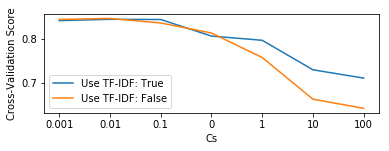

In [108]:
# Graph Results
scores = [x[1] for x in gs_clf.grid_scores_]
scores = np.array(scores).reshape(len(alphas), len(use_idf))

fig = plt.figure(1)
ax2 = fig.add_subplot(212)

a = np.arange(len(alphas))
# for ind, i in enumerate(use_idf):
ax2.plot(a, scores[:,0], label='Use TF-IDF: ' + str(use_idf[0]))
ax2.plot(a, scores[:,1], label='Use TF-IDF: ' + str(use_idf[1]))

ax2.xaxis.set_ticks(a)
ax2.xaxis.set_ticklabels(alphas)

plt.legend()
plt.xlabel('Alphas')
plt.ylabel('Cross-Validation Score')
plt.show()

## Logistic Regression Grid Search

In [118]:
### Logisitic Regression
clf = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_words)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])
alphas = [0.001,0.01,.1,1,10,100]
parameters = {'tfidf__use_idf':(True,False),
              'clf__C':alphas }
gs_clf = GridSearchCV(clf,parameters, n_jobs=-1)
gs_clf = gs_clf.fit(df_train.text, df_train.label)
gs_clf_log = gs_clf

/home/max/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


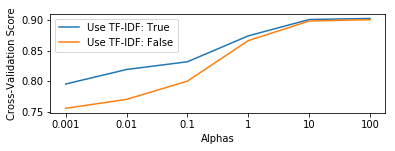

In [114]:
# Graph Results
scores = [x[1] for x in gs_clf.grid_scores_]
scores = np.array(scores).reshape(len(alphas), len(use_idf))

fig = plt.figure(1)
ax2 = fig.add_subplot(212)

a = np.arange(len(alphas))
# for ind, i in enumerate(use_idf):
ax2.plot(a, scores[:,0], label='Use TF-IDF: ' + str(use_idf[0]))
ax2.plot(a, scores[:,1], label='Use TF-IDF: ' + str(use_idf[1]))

ax2.xaxis.set_ticks(a)
ax2.xaxis.set_ticklabels(alphas)

plt.legend()
plt.xlabel('Alphas')
plt.ylabel('Cross-Validation Score')
plt.show()

In [115]:
predictions = gs_clf.predict(df_test.text)
f1 = f1_score(y_test, predictions, average='macro') 

accuracy = np.mean(predictions == df_test.label)

print("MNB: \nf1_score: {}\naccuracy: {} ".format(f1,accuracy))

MNB: 
f1_score: 0.9149243626207764
accuracy: 0.9149348362099331 


In [ ]:
joblib.dump(tfidf_transformer, 'Classifiers/tfidf_transformer.pkl')
joblib.dump(count_vect, 'Classifiers/count_vect.pkl')
joblib.dump(gs_clf_mnb, 'Classifiers/mnb_clf.pkl')
joblib.dump(gs_clf_svm, 'Classifiers/svm_clf.pkl')
joblib.dump(gs_clf_log, 'Classifiers/log_clf.pkl')

In [ ]:
# BAG with binary values
MNB:  0.861208256256
ADA:  0.88692961527
SVM:  0.923427548456
## not removing words 
MNB:  0.852378705631
ADA:  0.899721784937
SVM:  0.92836786749

# BAG with counts
MNB:  0.84710843052
ADA:  0.886742948335
SVM:  0.898489979131
## not removing them stop_words
MNB:  0.842206021811
ADA:  0.908575135645
SVM:  0.890657568726

    
# TF-IDF with counts
MNB:  0.837786994578
ADA:  0.896513330028
SVM:  0.937466064963
## not removing stop_words
MNB:  0.812818743373
ADA:  0.895799488985
SVM:  0.918595836606

# TF-IDF with binary
MNB:  0.839523809524
ADA:  0.904650376856
SVM:  0.941407136367
## not removing stop_words
MNB:  0.836683634874
ADA:  0.88884002199
SVM:  0.936449567452


# 10 Most Positive and Negative associated weights

In [130]:
theta = svm_clf.coef_
word_map = count_vect.get_feature_names()

# Find the indicies of the 5 most positive values in theta
indicies = theta[0].argsort()[-10:][::-1]
print("The 10 unigrams/bigrams with the most positive associated weights:")
for i in indicies:
    print("\t{}".format(word_map[i]))

indicies = theta[0].argsort()[:10]
print("The 10 unigrams/bigrams with the most positive associated weights:")
for i in indicies:
    print("\t{}".format(word_map[i]))

The 10 unigrams/bigrams with the most positive associated weights:
	https
	ap
	radio
	source
	loading
	декабря
	think
	pic
	rep
	donate
The 10 unigrams/bigrams with the most positive associated weights:
	reuters
	newsroom
	photo
	said
	november
	august
	credit
	caption
	2017
	story


## Classifier using Punctuation and Classification

In [60]:
# Add punctuation feature
data['text']

(1600, 42196)